### Multiclass model evaluation. 

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_pickle('../Dades/emotion/merged_training.pkl')
df.shape

(416809, 2)

In [3]:
df.head()

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love


In [4]:
X_train, X_test = train_test_split(df, test_size = 0.2, random_state = 1234)
X_train.shape, X_test.shape

((333447, 2), (83362, 2))

In [5]:
from nbc import NBCtext

In [6]:
_nbc = NBCtext()

In [7]:
%%time
_nbc.fit(X_train)

CPU times: total: 51.8 s
Wall time: 52.4 s


In [8]:
X_test['predict'] = X_test.text.apply(lambda x: _nbc.predict(x, alpha = 1, soft = False))

### Confusion Matrix for multiclass classification

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

In [10]:
sns.set_theme(context = 'notebook', style = "white", font_scale = 1.0)

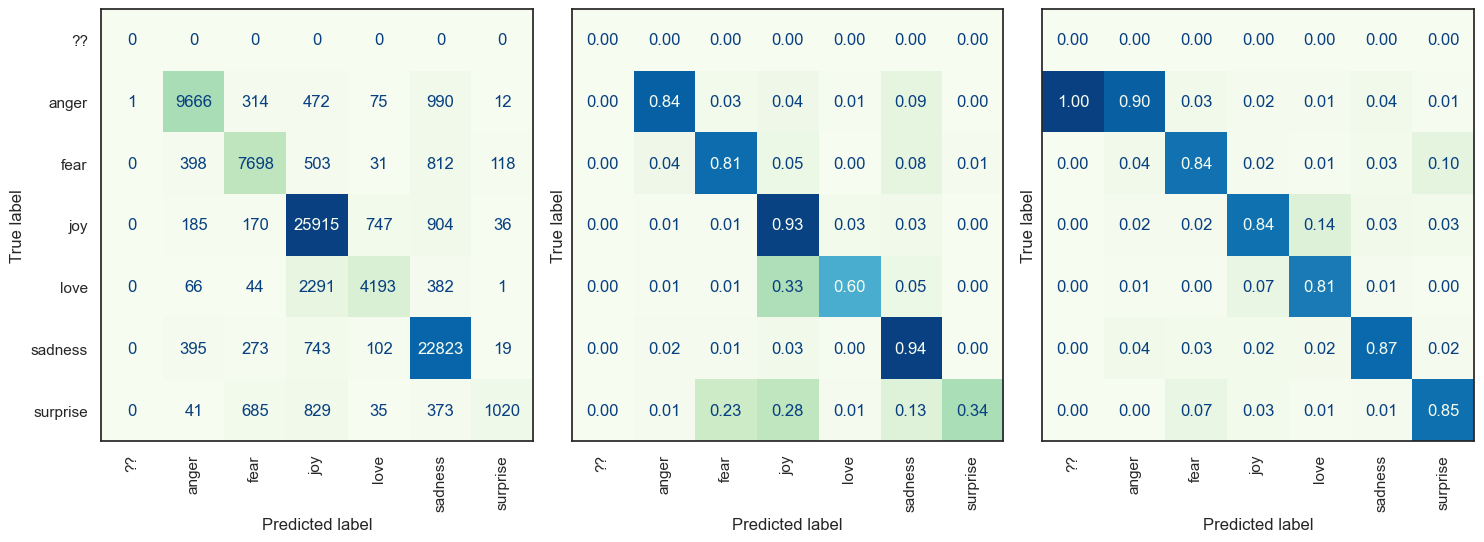

In [11]:
_, axs = plt.subplots(1, 3, figsize = (15, 6), sharey = True)
for i, norm in enumerate([None, 'true', 'pred']): 
    # true: Normalització respecte true són els valors dividits pel total. Per la casella del la diagonal és el recall
    # pred: Normalització respecte els que hem predit (la vertical) a la diagonal la presició
    ConfusionMatrixDisplay.from_predictions(
        X_test.emotions,
        X_test.predict,
        normalize = norm, # Posem aquesta informació aquí.
        values_format = '.2f' if norm is not None else '.0f',
        ax = axs[i],
        colorbar = False,
        cmap = 'GnBu',
        xticks_rotation = 90)
plt.tight_layout();

- 100 que són (etiqueta real) love 60 (correcte) si 33 (predim com joy) no i diriem x grafica del mig. Aquest fa referència al real (llegir per files)

- El de la dreta. De cada 100 que predim que es love 81 endevina i 14 que diem que es love, era joy (llegir per columnes)

- A la diagonal estem mirant el accuracy (el true positive)
- Cuadradets de fora la diagonal, però més pujadets de to &rarr; que signifiquen?
- Quan predim alegria, el 84% dels cops ho petem el 7% resulta que és amor (a la de la dreta del tot).
- En canvi en termes de recall, a tots els que són de amor, el 33% els classifiquem com alegria. Això és degut a que els totals són diferents. Les prediccións són diferents.

###  Performance measures for multiclass classification

In [12]:
from sklearn.metrics import accuracy_score
accuracy_score(X_test.emotions, X_test.predict)

0.8554857129147573

Suma de les diagonals dividit pel total. 

In [13]:
from sklearn.metrics import precision_recall_fscore_support as prfs

Calculem les altres. 

#### performance measures by class

El parametre zero division, es per si es troba un 0, li posa un 0, perquè no peti. podem fer que posi altres coses, per això serveix aquest parametres. 

In [14]:
pd.DataFrame(prfs(X_test.emotions, X_test.predict, zero_division = 0), columns = np.sort(X_test.predict.unique()), index = ['precision', 'recall', 'f_score', 'support'])

,??,anger,fear,joy,love,sadness,surprise
precision,0.0,0.899079,0.838197,0.842682,0.808991,0.868323,0.845771
recall,0.0,0.838335,0.805230,0.926959,0.600975,0.937097,0.341938
f_score,0.0,0.867645,0.821383,0.882814,0.689638,0.901400,0.486990
support,0.0,11530.000000,9560.000000,27957.000000,6977.000000,24355.000000,2983.000000


Aquí no hi ha el parametre average, aquest metode prfs, retornara totes les metriques presicio, recall, f_score, support &rarr; classe per classe.
<br/>
Les metriques i els seus valors. 
<br/>
Ara podem fer els promitjos separats. 

##### averaged performance measures

In [15]:
avrgs = ['macro', 'micro', 'weighted']
pd.DataFrame([prfs(X_test.emotions, X_test.predict, average = mode, zero_division = 0)[:3] for mode in avrgs], columns = ['precision', 'recall', 'f-score'], index = avrgs)

,precision,recall,f-score
macro,0.729006,0.635791,0.664267
micro,0.855486,0.855486,0.855486
weighted,0.854750,0.855486,0.848769


En general, els models acostume a fallar on tenim menys dades. Això fa que el macro (totes el mateix pes) es veura afectat on hi ha més i estem fallant més. el weighted es veu arreglat perque les que tenen menys pes. Però no vol dir que un sigui més cert que l'altre, són diferents maneres de veure els numeros.

**Micro**: Suma de tots els de la diagonal, dividit per la suma de tots menys aquells. diagonal true positive de toes les clases, falsos positive són tots menys això. numero de prediccions correctes respecte totes les prediccions que fas. **No sé si es correcte**. 

<hr/>

# Resum

- Classe per clasificar etiquetes.
- Dos datasets (un es cas binari i l'altre multiclasse).
- Com representem els resultats del model i treure metriques, per provar diferents models per predir i saber quin és millor.
- Confusion matrix, metriques i promitjos de les metriques.